### Download data

In [1]:
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

train_all = datasets . MNIST ('../ data', train =True , download = True, transform=transform ) # 60K images
train_data , val_data = torch . utils . data . random_split (
train_all , [50000 , 10000 ], torch . Generator () . manual_seed (0 )) # train : 50K ; val : 10K
test_data = datasets . MNIST ('../ data', train = False, download = True, transform=transform ) # test : 10K

/Users/Lanado/anaconda3/envs/my_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
from torch.utils.data import DataLoader, random_split
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Part 1: 10-class softmax classifer

In [3]:
import torch.nn as nn
class SoftmaxClassifier(nn.Module):
    def __init__(self):
        super(SoftmaxClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x

model = SoftmaxClassifier()

#### Train classifier via gradient descent

In [4]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [5]:
for epoch in range(10):  # number of epochs
    train(train_loader, model, criterion, optimizer)


#### Report accuracy

In [13]:
import torchmetrics
def test(dataloader, model):
    model.eval()
    accuracy = torchmetrics.Accuracy(num_classes=10, average='macro', task='multiclass')
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            accuracy.update(pred, y)
    return accuracy
    

# Evaluate on test data
accuracy = test(test_loader, model)
print(f"Test Accuracy: {(100 * accuracy.compute()): }%")

Test Accuracy:  91.29400634765625%


## Part 2: Hidden units, using ReLU as the activation function

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


new_model = NeuralNetwork()

#### Train new model

In [8]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
new_optimizer = optim.SGD(new_model.parameters(), lr=0.01)
for epoch in range(10):  # number of epochs
    train(train_loader, new_model, criterion, new_optimizer)

#### Report accuracy

In [18]:
accuracies = [test(test_loader, new_model).compute()]
print(f"Test Accuracy: {(100 * accuracies[0]): }%")

Test Accuracy:  94.45227813720703%


Notice the model with hidden layer has a higher accuracy compared to our first model. A softmax classifier without a hidden layer is essentially a linear model, which may not be sufficient to capture the complexities and variations in the handwritten digits. By adding a hidden layer, we increase the model's complexity, enabling it to learn more nuanced patterns in the data, like the curves and intersections in handwritten digits. By incorporating non-linear activation functions like ReLU in the hidden layer, the model can learn non-linear relationships. The hidden layer also helps in features transformation, converting the raw pixel values into a more abstract representation that captures the essence of the digits. For instance, the hidden layer might learn to identify important features like edges, curves, and angles, which are crucial in distinguishing between digits.

## Part 3: Number of hidden units per layer

1. The input-to-first-hidden-layer weight matrix has dimensions $28 * 28 = 784$ by the number of hidden units, $U$.
2. Each subsequent hidden layer has a weight matrix of $U * U$ as each layer is fully connected to the next.
3. Each hidden layer has a bias term for each of its $U$ units. 
4. The final layer (softmax classifier) has a weight matrix of $U * 10$ and a bias of $10$.

- First term gives the parameters in the input-to-first-hidden-layer weight matrix -> $784 * U$
- Second term gives the parameters in the hidden-to-hidden layer weight matrices for $L$ layers ->  $L$ * $U^{2}$
- Third term gives the parameters in hidden layer bias for $L$ layers -> $L$ * $U$
- Fourth term gives the parameters in the softmax classifier: $U * 10 + 10$

Summing all the terms we get: 

$784U + LU^{2} + LU + U * 10 + 10 = 814,090$ (keeping the same number of parameters given)

$LU^{2} + (784 + L + 10)U + 10 - 814,090 = 0$

$LU^{2} + (794 + L)U - 814,080 = 0$

Applying quadratic equation $aU^{2} + bU + c = 0$ in which
$
U = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$


Pluggin in, we have

$$
U = \frac{-(794 + L) \pm \sqrt{(794 + L)^2 + 4*L*814,080}}{2L}
$$

We will only take positive root of the square root $ \sqrt{b^2 - 4ac}$, and after calculating $U$, we will only keep the positive value as well as rounding up to the nearest integer as it represents the number of hidden units. This the derived number of  number of hidden units per layer as a function of $L$.

## Part 4: MLP Model with different number of layers

In [10]:
def build_model(L):
    layers = [nn.Flatten(), nn.Linear(28*28, 1024), nn.ReLU()]
    for _ in range(L - 1):
        layers += [nn.Linear(1024, 1024), nn.ReLU()]
    layers += [nn.Linear(1024, 10)]  # Output layer
    return nn.Sequential(*layers)

In [11]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")


In [19]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Train and evaluate the model with different L
num_hidden_layers = [2, 3, 4, 5, 6, 7, 8]
for L in num_hidden_layers:
    print(f"Training model with {L} hidden layers")
    MLP_model = build_model(L)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(MLP_model.parameters(), lr=0.01)
    train_model(MLP_model, train_loader, criterion, optimizer)
    #accuracy = evaluate_model(model, test_loader)
    accuracy = test(test_loader, MLP_model).compute()
    accuracies.append(accuracy)
    print(f"Test Accuracy for L={L}: {accuracy * 100:.2f}%\n")

Training model with 2 hidden layers
Epoch 1/10, Loss: 0.9166927490659686
Epoch 2/10, Loss: 0.36894990213196294
Epoch 3/10, Loss: 0.31268416867231774
Epoch 4/10, Loss: 0.28063612331248
Epoch 5/10, Loss: 0.2547606171949593
Epoch 6/10, Loss: 0.2324313048721122
Epoch 7/10, Loss: 0.21242712552437698
Epoch 8/10, Loss: 0.19445851639084652
Epoch 9/10, Loss: 0.17946789455135612
Epoch 10/10, Loss: 0.16587445467396084
Test Accuracy for L=2: 94.75%

Training model with 3 hidden layers
Epoch 1/10, Loss: 1.2460514711754402
Epoch 2/10, Loss: 0.401730692962094
Epoch 3/10, Loss: 0.3228894882189953
Epoch 4/10, Loss: 0.28221204427197155
Epoch 5/10, Loss: 0.25262345509398776
Epoch 6/10, Loss: 0.2258174107660113
Epoch 7/10, Loss: 0.2044837485732096
Epoch 8/10, Loss: 0.1845910330172009
Epoch 9/10, Loss: 0.16807966187710652
Epoch 10/10, Loss: 0.15302764068898336
Test Accuracy for L=3: 95.32%

Training model with 4 hidden layers
Epoch 1/10, Loss: 1.8117488581506187
Epoch 2/10, Loss: 0.516696341183332
Epoch 3/

[tensor(0.9445), tensor(0.9475), tensor(0.9532), tensor(0.9565), tensor(0.9511), tensor(0.9599), tensor(0.9028), tensor(0.2560)]


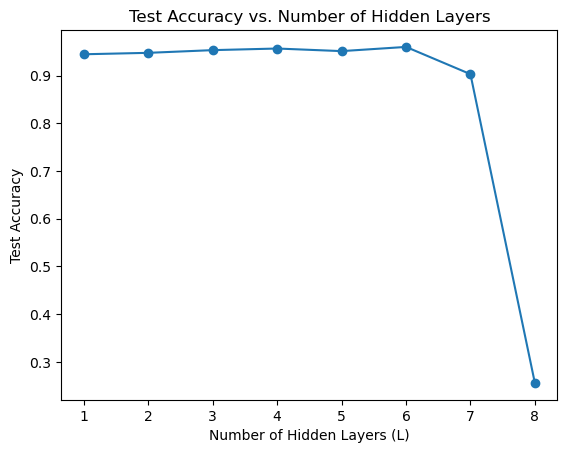

In [23]:
import matplotlib.pyplot as plt
print(accuracies)
plt.plot(range(1, 9), accuracies, marker='o')
plt.xlabel('Number of Hidden Layers (L)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Hidden Layers')
plt.show()

From the 1st to 4th layer, we can see the increase in accuracy, however after the 4th layer, accuracy slightly dips down but comes back up again on 6th layer. It reports the highest accuracy at layer 6 of 95.99%. However, at layer 7th, the accuracy falls even lower compare to 1 layer. Then at layer 8th, the accuracy is at its lower only 25.60% which is a huge decrease from all the other layers that we tested. 

We can conclude that increasing the number of hidden layers does not always mean increasing the accuracy of the model. Especially with a high number of hidden layers, it can cause overfitting and other optimization challenges. As the depth of the network increases, the model becomes more complex and capable of learning fine-grained details in the training data, but poorly on unseen data (test data). Deeper networks can also be harder to optimize. They have more parameters and can get stuck in suboptimal regions of the parameter space (like local minima or saddle points).